# Module Tests

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from icecream import ic

from src.plotting import plot_boundaries, plot_particles

## System creator

In [ ]:
# system
from src.system_creator import SystemCreator

# Tube creation :
tube_segments = 0.001*np.array([[0,0,10,0], [0,0,0,1], [10,0,10,1], [0,1,10,1]])
tube = SystemCreator(tube_segments)

offsets = tube.get_offsets()
system_shape = tube.system_shape()
a = tube.get_dir_vects()

ic(offsets)
ic(system_shape)
ic(a)

# Cylinder
circle = [[5+np.cos(k*np.pi/8), 5+np.sin(k*np.pi/8), 5+np.cos((k+1)*np.pi/8), 5+np.sin((k+1)*np.pi/8)] for k in range(16)]
cylinder_segments = 0.001*np.array([[0,0,10,0], [0,0,0,10], [10,0,10,10], [0,10,10,10]]+circle)
cylinder = SystemCreator(cylinder_segments)

ic(cylinder.get_offsets())
ic(cylinder.system_shape())
ic(cylinder.get_dir_vects())

In [ ]:
fig, ax = plt.subplots()
plot_boundaries(ax, tube_segments)
plt.show()

In [ ]:
fig, ax = plt.subplots()
plot_boundaries(ax, cylinder_segments)
plt.show()

## Particle

In [ ]:
from src.utils import Particle, get_mass_part

# Iodine
container = Particle('I', 0, get_mass_part(53, 53, 74), radius = 2e-10, size_array = 10000)
N = 500
arr =  np.random.random((N,5))
ic(container.get_params()); # mass, charge, radius, cross-section

In [ ]:
container.add_multiple(arr)
ic(container.get_current())
ic(container.get_particles().shape)
ic(container.arr.shape);

In [ ]:
ic(container.get_current())
for k in range(3):
    container.add_multiple(np.random.random((1000,5)))
    ic(container.get_current())
    container.delete_multiple(np.random.choice(a = container.get_current(), size = 500, replace = False))
    ic(container.get_current())

In [ ]:
# TODO : make 'dynamic' arrays (when increasing the size).
container.add_multiple(np.random.random((3000,5)))
ic(container.get_current())

**Conclusion**  : make 'dynamic' array (can increase time, but not decrease it for example).

## Grid
For now : 2D-ndarray with value of type *ndarray* which are 2D.
```python
# grid[x_int, y_int] is the container for a cell
# grid[x_int, y_int][idx] contains the particle indexes
grid[x_int, y_int][idx] = [idx_container, idx_particle_in_container]
```

In [ ]:
from src.utils import Grid, pos_in_grid
resolutions = np.array([4,4])
max_number_per_cell = 10 # to initialize the array which will contain the particles indexes

In [ ]:
grid = Grid(resolutions, max_number_per_cell)

In [ ]:
# x, y, vx, vy, vz
arr = np.array([[-1.5,1.2,1,0,0], [-1.3,-0.8,0,-1,0], [1.3,-0.5,-1,0,0], [1,1,-1,-1,-1], [-1,1,1,0,0]])
ic(arr);

In [ ]:
# signature : pos_in_grid(pos, grid_res, offsets, system_shape)
pos = pos_in_grid(arr[:,:2], resolutions, offsets = np.array([-2, -2]), system_shape = np.array([4,4])) # not inplace
ic(pos);

In [ ]:
# [pos_x, pos_y, idx_container, idx_particle_in_container]
idx_container = np.array([0,0,0,0,0])
idx_particle_in_container = np.array([0,1,2,3,4])
idxes = np.stack((idx_container, idx_particle_in_container), axis = 1)
new_arr = np.concatenate((pos, idxes), axis = 1)
ic(new_arr);

In [ ]:
grid.reset()
grid.add_multiple(new_arr)
ic(grid.current);
ic(grid.get([0,1]));

In [ ]:
# TODO : delete multiple
grid.delete([0,1], 0) # can still take lots of time
ic(grid.current);
ic(grid.get([0,1]));

**Conclusion** :
- Add a 'delete_multiple' built on *NumPy*.
- Maybe change the grid to a 4D-array :
    - Pro : faster everything.
    - Cons : waste of memory for system with density gradients, increasing size of the array costs much more.

## Injector 

In [ ]:
%matplotlib inline 
# notebook
from src.plotting import plot_particles, plot_boundaries
from src.utils import inject 
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [ ]:
# Signature : inject(in_wall, in_vect, debit, vel_std, radius, dt)
in_wall =  np.array([0,0,0,1]) # np.array([0,0,0,1]) # np.array([0,0,1,0]) # np.array([0,0,0,1]) # np.array([0,0,1,1])
a = np.array([0,1,1])
in_vect = np.array([1,0]) # (1/np.sqrt(2))*np.array([-1,1]) # -np.array([1,0]) #  -np.array([0,1]) # np.array([1,0])# (1/np.sqrt(2))*np.array([1,1])
debit = 100000000 # particles / s
dt = 0.001
vel_std = 200. # m/s
radius = 0.01

In [ ]:
arr, remains = inject(in_wall, in_vect, debit, vel_std, radius, dt)

In [ ]:
fig, ax = plt.subplots()
plot_boundaries(ax, np.expand_dims(in_wall, axis = 0))
plot_particles(ax, arr, r = 10*radius, arrows = False)
plt.axis('equal');

In [ ]:
df = pd.DataFrame(arr, columns = ['x', 'y', 'vx', 'vy', 'vz'])

In [ ]:
#ProfileReport(df)

In [ ]:
fig, ax = plt.subplots(2,2)
df['vx'].plot.hist(bins=50, ax = ax[0,0])
df['vy'].plot.hist(bins=50, ax = ax[0,1])
df['x'].plot.hist(bins=50, ax = ax[1,0])
df['y'].plot.hist(bins=50, ax = ax[1,1]);

## Advection (and schemes)

In [ ]:
from src.utils import advect
from src.utils import euler_explicit, leap_frog
from src.plotting import plot_particles, plot_boundaries
from icecream import ic
%matplotlib inline
# notebook
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# signature : advect(arr, f, dt, args, scheme)
arr = np.array([[1,1,1,1,0], [2,1,-1,-1,0]], dtype = float)
#arr = np.random.random((10,5))
def f(arr, dt):
    return np.zeros(shape = (arr.shape[0], 3))

In [ ]:
arr_ = np.copy(arr)
advect(arr_, f, dt = 0.1, args = [], scheme = euler_explicit) # seems ok

In [ ]:
arr__ =  np.copy(arr)
advect(arr__, f, dt = 0.1, args = [], scheme = leap_frog) # seems ok

In [ ]:
fig, ax = plt.subplots()
plot_particles(ax, arr, r = 10) 
plot_particles(ax, arr_, r = 10)

## Collision with walls

In [ ]:
%matplotlib inline
# notebook
from src.plotting import plot_boundaries, plot_particles
import matplotlib.pyplot as plt
from icecream import ic

In [ ]:
from src.utils import handler_wall_collision, make_collisions, make_collisions_vectorized, make_collisions_out_walls
import numpy as np
N = 10
walls = 1.5*np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]]) # bottom, left, right, top
a = np.array([[1,0, 1.5],[0,1, 1.5],[0,1, 1.5],[1,0, 1.5]])
# arr = np.array([[2,0.5,1,0,0], [0.5,2,0,1,0], [2,2,1,1,0], [0.5,0.5,1,0,0], [-0.5,0.5,-1,0,0]])  # np.random.random((N,5)) # 
arr = np.array([[1.5,2,1,1,0]])
arr[:,2:] = 5*arr[:,2:]
radius = 0.1
idx_out_walls = [2]

In [ ]:
fig, ax = plt.subplots()
plot_boundaries(ax, walls)
plot_particles(ax, arr, r = 8, arrows = True)
plt.axis('equal');

In [ ]:
ct, cp = handler_wall_collision(arr, walls, a, radius)

In [ ]:
new_arr_1 = np.copy(arr)
new_arr_2 = np.copy(arr)
new_arr_3 = np.copy(arr)
make_collisions(new_arr_1, a, ct, cp)
make_collisions_vectorized(new_arr_2, a, ct, cp)
indexes = make_collisions_out_walls(new_arr_3, a, ct, cp, idx_out_walls)
ic(indexes)

In [ ]:
fig, ax = plt.subplots(2,2)

plot_boundaries(ax[0,0], walls)
plot_particles(ax[0,0], arr, r = 8, arrows = True)

plot_boundaries(ax[0,1], walls)
plot_particles(ax[0,1], new_arr_1, r = 8, arrows = True)

plot_boundaries(ax[1,0], walls)
plot_particles(ax[1,0], new_arr_2, r = 8, arrows = True)

plot_boundaries(ax[1,1], walls)
plot_particles(ax[1,1], new_arr_3, r = 8, arrows = True)

ax[0,0].axis('equal')
ax[0,1].axis('equal')
ax[1,0].axis('equal')
ax[1,1].axis('equal')
fig.tight_layout();

#### Collision with walls - and outwalls

Problem : sometimes a particle can collide and be reflected but remain outside the system. In such a case, we have to make sure the particle is reflected again, and as many time as necessary. In addition, particles that went out (by the out walls) should be taken into account and :
 - not reflected back into the system but instead removed
 - a particle can, after its second reflection in a row, finds itself going trough the 'out wall'. In such a case it should be added to the list of particle to delete.

In [ ]:
from src.utils import handler_wall_collision, make_collisions, make_collisions_vectorized, make_collisions_out_walls
import numpy as np
%matplotlib notebook
from src.plotting import plot_boundaries, plot_particles
import matplotlib.pyplot as plt
from icecream import ic

N = 10
segments = 1.5*np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]]) # bottom, left, right, top
a = np.array([[1,0, 1.5],[0,1, 1.5],[0,1, 1.5],[1,0, 1.5]])
arr = np.array([[-4,5.5,-1,1,0], [1.6,2,1,1,0],[2,0.5,1,0,0], [2,2,1,1,0], [0.5,0.5,1,0,0], [-0.5,0.5,-1,0,0]])  # np.random.random((N,5)) # 
radius = 0.01
idx_out_walls = [2] # 2 : Right
fig, ax = plt.subplots()
plot_boundaries(ax, segments)
plot_particles(ax, arr, r = 8, arrows = True)
plt.axis('equal');

In [ ]:
count = np.full(shape = (arr.shape[0]), fill_value = True)
idxes_out = []
c = 0
while(np.sum(count, where = count == True) > 0):
        ic(c)
        c+=1
        ct, cp = handler_wall_collision(arr[count], segments, a, radius)
        ic(cp)
        count, idxes_out_ = make_collisions_out_walls(arr, a, ct, cp, idx_out_walls, count) # idxes_out : indexes of the particles (in arr) that got out of the system
        idxes_out.append(idxes_out_)
        fig, ax = plt.subplots()
        plot_boundaries(ax, segments)
        plot_particles(ax, arr, r = 8, arrows = True)
        plt.axis('equal');
        
        #print(count)
        if(c>20):
            break
ic(c)
np.concatenate(idxes_out)

arr[idxes.shape[0]:,:] = np.delete(self.arr, idxes, axis = 0) # operation is not inplace
current-=idxes.shape[0]

## Particles collisions

Signatures of the functions :
* candidates(currents, dt, average, pmax, volume_cell, mr, remains)
* index_choosen_couples(current, candidates)
* probability(vr_norm, pmax, cross_sections)
* is_colliding(proba)
* reflect(arr, vr_norm)


In [ ]:
%matplotlib notebook
from src.utils import candidates, index_choosen_couples, probability, is_colliding, reflect
import numpy as np
from icecream import ic
from src.plotting import plot_particles, plot_grid
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
currents = 10*np.array([
    [16,22,14],
    [9,13,11],
    [4,9,6]
])
ic(currents.shape)
dt = 1e-7
averages = 10*np.array([
    [15,20,15],
    [10,15,10],
    [5,10,5]
])
radius = 2e-10
cross_section = 4 * np.pi * radius**2
pmax = cross_section * 600
volume_cell = (0.001)**3
mr = 1e15
remains = 0

In [ ]:
remains, cands = candidates(currents, dt, averages, pmax, volume_cell, mr, remains)
ic(cands);

In [ ]:
arrays = [np.random.uniform(low = -1, high = 1, size = (current, 5)) for current in currents.flatten()]
arr = np.concatenate(arrays, axis = 0)
arr_save = np.copy(arr)
ic(arr.shape);

In [ ]:

grid_shape = currents.shape
system_shape = (2.,2.)
offsets = np.array([-1, -1])
fig, ax = plt.subplots()
plot_grid(ax, grid_shape, system_shape, offsets)
plot_particles(ax, arr, r = 0.1)
plt.axis('equal')
plt.show()

In [ ]:
for count, (i, j) in enumerate(np.ndindex(currents.shape)):
    choice = index_choosen_couples(currents[i,j], int(cands[i,j]))
    vr_norm = np.linalg.norm((arrays[count][choice][:,1,2:]-arrays[count][choice][:,0,2:]), axis = 1)
    proba = probability(vr_norm = vr_norm, pmax = pmax, cross_sections = cross_section)
    collidings_couples = is_colliding(proba)
    ic(np.sum(collidings_couples))
    # if(not all(~collidings_couples)):
    #    ic(all(~collidings_couples))
    #    ic(arr)
    # can not be inplace
    arrays[count][choice[collidings_couples]] = reflect(arrays[count][choice[collidings_couples]], vr_norm[collidings_couples])


In [ ]:
import pandas as pd

In [ ]:
arr = np.concatenate(arrays, axis = 0)
df1 = pd.DataFrame(arr_save, columns = ['x','y','vx','vy','vz'])
df2 = pd.DataFrame(arr, columns = ['x','y','vx','vy','vz'])

In [ ]:
fig, ax = plt.subplots(2,2)
df1['vx'].plot.hist(bins=50, ax = ax[0,0])
df1['vy'].plot.hist(bins=50, ax = ax[0,1])
df2['vx'].plot.hist(bins=50, ax = ax[1,0])
df2['vy'].plot.hist(bins=50, ax = ax[1,1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(2,2)

sns.histplot(df1, x="x", y="y", weights = 'vx', stat = 'density', bins = 3, ax = ax[0,0])
sns.histplot(df2, x="x", y="y", weights = 'vx', stat = 'density', bins = 3, ax = ax[0,1])
sns.histplot(df1, x="x", y="y", weights = 'vy', stat = 'density', bins = 3, ax = ax[1,0])
sns.histplot(df2, x="x", y="y", weights = 'vy', stat = 'density', bins = 3, ax = ax[1,1])

# ax[0,0].scatter(pd1['x'],pd1['y'], c=pd1['vx'], s=100)
# ax[0,1].scatter(pd2['x'],pd2['y'], c=pd2['vy'], s=100)
# ax[1,0].scatter(pd1['x'],pd1['y'], c=pd1['vx'], s=100)
# ax[1,1].scatter(pd2['x'],pd2['y'], c=pd2['vy'], s=100)

plt.show()

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

#fig, ax = plt.subplots()
g = sns.JointGrid(data=df1, x="vx", y="vy", space=0)
g.plot_joint(sns.kdeplot,
             fill=True,
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

#fig, ax = plt.subplots()
g = sns.JointGrid(data=df2, x="vx", y="vy", space=0)
g.plot_joint(sns.kdeplot,
             fill=True,
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x = df1['x']
y = df2['y']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x,y, c=z, s=100)
plt.show()

### From grid, get particles



In [ ]:
import numpy as np
from icecream import ic
from src.utils import candidates, index_choosen_couples, probability, is_colliding, reflect

currents = 10*np.array([
    [24,26],
    [25,25]
], dtype = int)

arr = [np.random.uniform(low = -1.0, high = 1.0, size = (1000,5))]
arr_copy = np.copy(arr[0])
# zer = np.zeros(250)
t = np.arange(1000)
np.random.shuffle(t)
arr1, arr2, arr3, arr4 = np.split(t, indices_or_sections = [240,500,750], axis = 0)
p1, p2 = np.stack((np.zeros(240), arr1), axis = 1), np.stack((np.zeros(260), arr2), axis = 1)
p3, p4 = np.stack((np.zeros(250), arr3), axis = 1), np.stack((np.zeros(250), arr4), axis = 1)

grid = np.array([
    [p1, p2],
    [p3, p4]],
    dtype = np.ndarray)

ic(currents);

In [ ]:
# Now we have to get all that is in arr from grid...
# and do this in place ... which will be VERY fucking hard
# VERY SLOW
cands = np.array([[120,123],[124,124]])
cross_section = 1
pmax = 2
for k, (i, j) in enumerate(np.ndindex(currents.shape)):
    choice = index_choosen_couples(currents[i,j], int(cands[i,j])) # choice contains the possible couples
    # now, we have to get their pos and speed
    g = grid[i,j]
    parts = np.array([[g[c[0]], g[c[1]]] for c in choice], dtype = int)
    array = np.array([[ arr[c[0,0]][c[0,1]] , arr[c[1,0]][c[1,1]] ] for c in parts])
    # blablabla [...] -> DSMC etc.
    # TODO: make those stuff and see if it still works

    vr_norm = np.linalg.norm((array[:,1,2:]-array[:,0,2:]), axis = 1)
    proba = probability(vr_norm = vr_norm, pmax = pmax, cross_sections = cross_section)

    # TODO : should update pmax here (or return something)...
    collidings_couples = is_colliding(proba)
    array[collidings_couples] = reflect(array[collidings_couples], vr_norm[collidings_couples])
    
    for k in range(len(array)):
        c1, c2 = array[k,0], array[k,1]
        c = parts[k]
        arr[c[0,0]][c[0,1]][:] = c1 # copy
        arr[c[1,0]][c[1,1]][:] = c2
        

In [ ]:
np.array_equal(arr_copy, arr[0])

### Reflection study 

TODO: make sure this is done correctly

In [ ]:
from src.utils import reflect
import numpy as np
from icecream import ic

arr = np.array([[[1,1,1,1,1], [1,1,-1,-1,1]]])
vr_norm = np.linalg.norm((arr[:,1,2:]-arr[:,0,2:]), axis = 1)

In [ ]:
arr_ = reflect(np.copy(arr),vr_norm)

In [ ]:
ic(arr);
ic(arr_);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def get_list_angles(N=10000):    
    r = np.random.rand(N)    
    q = 2*r-1
    
    return 2*np.pi*np.random.rand(N), q, np.sqrt(1-q*q)

def plot_list_angles(PHI, CTHETA, STHETA):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    R = 1
    X = R * STHETA * np.cos(PHI)
    Y = R * STHETA * np.sin(PHI)
    Z = R * CTHETA

    ax.scatter(X, Y, Z, c='r', marker='o', s=1)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

## Update position in grids - tests

##### Idea : 
1. Create particles and initialize them in the grids
2. Do something 
3. Update position in the grid

For now, we are simply resetting all of them as it does not cost much to do so. (structured grid)

In [ ]:
from src.utils import Grid, pos_in_grid
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
%matplotlib notebook

N = 100
arr = np.random.uniform(low = -1, high = 1, size = (N,5))
grid = Grid(np.array([3,7]), 10)

from src.plotting import plot_particles, plot_grid
resolutions = (3,7)
system_shape = (2.,2.)
offsets = np.array([-1, -1])
fig, ax = plt.subplots()
plot_grid(ax, resolutions, system_shape, offsets)
plot_particles(ax, arr, r = 0.1)
plt.axis('equal')
plt.show()

In [ ]:
def convert_to_grid_datatype(positions, new, old = 0):
    index_container = np.zeros((new-old))
    index_in_container = np.arange(old, new)
    indexes = np.stack((index_container, index_in_container), axis = 1)
    return np.concatenate((positions, indexes), axis = 1).astype(int)

In [ ]:
positions = pos_in_grid(arr[:,:2], resolutions, offsets, system_shape)
particles = convert_to_grid_datatype(positions, new = positions.shape[0])
ic(particles[:10])
grid.add_multiple(particles)
ic(grid.current);

In [ ]:
grid.reset() # that's how we are going to do...
ic(grid.current);
grid.add_multiple(particles)
ic(grid.current);

# Integration test

Signatures :
 - SystemCreator(segments)
 - inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
 - advect(arr, f, dt, args, scheme)
 - handler_wall_collision(arr, walls, a, radius)
 - make_collisions_vectorized(arr, a, ct, cp)
 - Particle(part_type, charge, mass, radius, size_array)
 - Grid(resolutions, max_number_per_cell)
 - collider(arr, grid, currents, dt, average, pmax, cross_section, volume_cell, mr, remains)

In [1]:
%matplotlib notebook

# system
from src.system_creator import SystemCreator

# Grid
from src.utils import Grid, pos_in_grid

# Particles
from src.utils import Particle

# injection 
from src.utils import inject

# advection
from src.utils import advect
from src.utils import euler_explicit, leap_frog

# collisions
from src.utils import handler_wall_collision, handler_wall_collision_point, make_collisions_vectorized, make_collisions_out_walls

# utils 
from src.utils import gaussian, maxwellian_flux, maxwellian_mean_speed, get_mass_part

# plotting 
from src.plotting import plot_boundaries, plot_particles, plot_grid

# collisions between particles
from src.utils import handler_particles_collisions # candidates, index_choosen_couples, probability, is_colliding, reflect, 

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic
import pandas as pd
import seaborn as sns

np.random.seed(1111)

In [2]:
def thruster(w_in, l_in, w1, l1, l_int, w2, l2, w_out, l_out, offsets = np.array([0,0])):
    # hypothesis : w_int = w_in
    # returns an array with the walls for the thruster
    # not optimized but we prioritize the clarity here
    def rectangle(w,l, offset=np.array([0,0])):
        # top left point is p1 and then its trigo rotation
        p1 = np.array([0,0])+offset
        p2 = np.array([w,0])+offset
        p3 = np.array([w,-l])+offset
        p4 = np.array([0,-l])+offset
        return p1,p2,p3,p4

    p1, p2, p3, p20 = rectangle(w_in,l_in)
    p19, p4, p5, p18 = rectangle(w1,l1, offset = np.array([0.5*(w_in-w1),-l_in]))
    p17, p6, p7, p16 = rectangle(w_in,l_int, offset = np.array([0, -l1-l_in]))
    p15, p8, p9, p14 = rectangle(w2, l2, offset = np.array([0.5*(w_in-w2),-l_in-l1-l_int]))
    p13, p10, p11, p12 = rectangle(w_out, l_out, offset = np.array([0.5*(w_in-w_out),-l_in-l1-l_int-l2]))
    points = np.array([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20])
    segments = np.concatenate((points[1:],points[:19]), axis = 1)
    segments = np.concatenate((segments, np.expand_dims(np.concatenate((p20,p1)),axis = 0)), axis = 0)
    # sorting is realized when the array is created per the SystemCreator. No need to worry at this point.
    return segments

def mean_free_path(cross_section, density):
    return 1/(cross_section*density)

def mean_free_time(mfp, v_mean):
    return mfp/v_mean

In [3]:
iterations = 20000

# System :
dz = 0.001
# idx_out_walls = [1,2]
idx_out_walls = [0,10] # 2nd and 3rd walls are out walls.

    # tube
segments = 0.001*np.array([[0,0,10,0], [0,0,0,1], [10,0,10,1], [0,1,10,1]]) # tube
system = SystemCreator(segments)

    # Thruster
dp = 0.001
segments = thruster(w_in = 5*dp, l_in = 3*dp, w1 = 3*dp, l1 = dp, l_int = dp, w2 = dp, l2 = 5*dp, w_out = 5*dp, l_out = dp, offsets = np.array([0,0]))
system = SystemCreator(segments)
    # cylinder
# res = 4
# circle = [[1.5+0.5*np.cos(k*np.pi/res), 1+0.5*np.sin(k*np.pi/res), 1.5+0.5*np.cos((k+1)*np.pi/res), 1+0.5*np.sin((k+1)*np.pi/res)] for k in range(2*res)]
# segments = 0.001*np.array([[0,0,3,0], [0,0,0,2], [3,0,3,2], [0,2,3,2]]+circle)
# system = SystemCreator(segments)

offsets = system.get_offsets()
system_shape = system.system_shape()
a = system.get_dir_vects()
segments = system.get_segments()

# grid :
mean_number_per_cell = 1000
max_number_per_cell = 10*mean_number_per_cell
resolutions = np.array((5,11), dtype = int)
grid = Grid(resolutions, max_number_per_cell)
volume_cell = dz * system_shape[0]/resolutions[0] * system_shape[1]/resolutions[1]

# Particles - 1 type 
density = 3.2e19 # m-3
n_simu = mean_number_per_cell*np.sum(resolutions)
n_real = dz * system_shape[0] * system_shape[1] * density
mr = n_real/n_simu# macro particules ratio = number of particles in the real system / number of macro part in the simulated system
density_dsmc = density/mr
temperature = 300 # K

part_type = 'I'
charge, mass, radius = 0, get_mass_part(53, 53, 74), 2e-10
size_array = 2*max_number_per_cell*np.sum(resolutions)
v_mean = maxwellian_mean_speed(temperature, mass)
container = Particle(part_type, charge, mass, radius, size_array)
cross_section = container.get_params()[3]

# mean free path and time
mfp = mean_free_path(cross_section, density)
typical_lenght = 0.001
mft = mean_free_time(typical_lenght, v_mean = v_mean)

# Injection params
in_wall = np.array([0,0,0.005,0.0], dtype = float)
in_vect = np.array([0,-1], dtype = float)
debit = maxwellian_flux(density_dsmc, v_mean)*np.linalg.norm(in_wall[:2]-in_wall[2:])*dz
vel_std = gaussian(temperature, mass)
dt = 1e-6 # in sec, should be a fraction of the mean free time

# advection
def f(arr, dt):
    return np.zeros(shape = (arr.shape[0], 3))
args = []
scheme = euler_explicit

In [4]:
ic(v_mean);
ic(mfp);
ic(mft);
ic(debit*dt);

ic| v_mean: 222.84430705073834
ic| mfp: 0.062169899645271615
ic| mft: 4.487437948200826e-06
ic| debit*dt: 81.03429347299576


In [5]:
def plot(arr, segments, radius, gs, ss, offset):
    fig, ax = plt.subplots()
    plot_grid(ax, gs, ss, offset)
    plot_boundaries(ax, segments)
    if(arr is not None):
        plot_particles(ax, arr, radius)
    plt.axis('equal')
    plt.show()
    
def convert_to_grid_datatype(positions, new, old = 0):
    index_container = np.zeros((new-old))
    index_in_container = np.arange(old, new)
    indexes = np.stack((index_container, index_in_container), axis = 1)
    return np.concatenate((positions, indexes), axis = 1).astype(int)

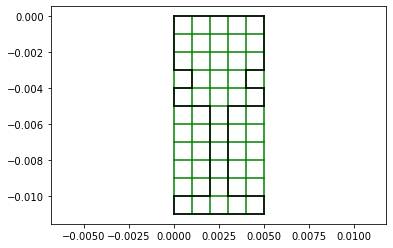

In [6]:
%matplotlib inline
plot(None, segments, radius, resolutions, system_shape, offsets)

In [7]:
%matplotlib inline
# print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(' it ', ' INIT ', ' INJECT ', ' DEL ', ' TRY'))
# print('{:-^56}'.format(''))

store = pd.HDFStore('0605_tube.h5')

remains = 0
df = pd.DataFrame(columns = ['x','y','vx','vy','vz'])
saving_period = 1
# dsmc saving
averages = np.full(shape = grid.current.shape, fill_value = mean_number_per_cell)
remains_per_cell = np.zeros(shape = grid.current.shape, dtype = float)
# pmax = np.full(shape = grid.current.shape, fill_value = 2*vel_std*cross_section)
pmax = 2*vel_std*cross_section
arr_nb_colls = np.zeros((iterations, resolutions[0], resolutions[1]))
for it in tqdm(range(iterations)): # tqdm
    n1 = container.get_current()
                   
    # injecting particles
    new, remains = inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
    container.add_multiple(new)
                   
    n2 = container.get_current()-n1
    
    # PHASE : ADVECTING
        # MOVING PARTICLES
    arr = container.get_particles()
    
    if(it%saving_period==0):
        df = df.append(pd.DataFrame(data=arr, index=[it]*arr.shape[0], columns = ['x','y','vx','vy','vz']))
    
    advect(arr, f, dt, args, scheme) # advect is inplace
    
        # HANDLING BOUNDARIES 
    # positions_save = np.copy(arr) # for later
    count = np.full(fill_value = True, shape = arr.shape[0])
    idxes_out = []
    c = 0
    while(np.sum(count, where = count == True) > 0):
        c+=1
        ct, cp = handler_wall_collision_point(arr[count], segments, a) # handler_wall_collision(arr[count], segments, a, radius)
        count, idxes_out_ = make_collisions_out_walls(arr, a, ct, cp, idx_out_walls, count) # idxes_out : indexes of the particles (in arr) that got out of the system
        idxes_out.append(idxes_out_)
        
    idxes_out = np.concatenate(idxes_out)
    container.delete_multiple(idxes_out)
    arr = container.get_particles()
    
    # PHASE : COLLISIONS
        # UPDATING GRID - HARD RESET
    grid.reset()
    positions = pos_in_grid(arr[:,:2], resolutions, offsets, system_shape)
    particles = convert_to_grid_datatype(positions, new = positions.shape[0])
    grid.add_multiple(particles)

        # DSMC
        # TODO: make parallel
    #arr_save = np.copy(arr)
    currents = grid.get_currents()
    remains_per_cell, nb_colls = handler_particles_collisions([arr], grid.get_grid(), currents, dt, averages, pmax, cross_section, volume_cell, mr, remains_per_cell)
    arr_nb_colls[it,:,:] = nb_colls
    # if(np.array_equal(arr_save, container.get_particles()) and np.sum(nb_colls)>0):
    #    print('Arrays are equals but there were collisions.')
    
    # PLOTTING (OPTIONAL)
    if(it%100==0):
        store.append('df', df)
        df = pd.DataFrame(columns = ['x','y','vx','vy','vz']) # this way not too much memory is used
        #plot(arr, segments, radius, resolutions, system_shape, offsets)
    #    print('{:^10}|{:^10}|{:^10}|{:^10}|{:^10}'.format(it, n1, n2, idxes_out.shape[0], c))
np.save(file = 'collisions.npy', arr = arr_nb_colls, allow_pickle=False)
store.append('df', df)

100%|██████████| 200/200 [00:01<00:00, 106.66it/s]


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.plotting import plot_boundaries, plot_particles, plot_grid


def plot(arr, segments, radius, gs, ss, offset):
    fig, ax = plt.subplots()
    plot_grid(ax, gs, ss, offset)
    plot_boundaries(ax, segments)
    if(arr is not None):
        plot_particles(ax, arr, radius)
    plt.axis('equal')
    plt.show()
    
store = pd.HDFStore('0605_tube.h5')
df = store['df']
arr_nb_colls = np.load('collisions.npy')

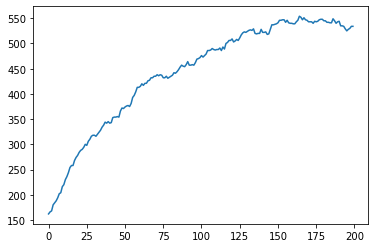

In [10]:
plt.plot(df.groupby(df.index).x.agg('count').values);

In [11]:
collisions_evo = np.sum(arr_nb_colls, axis = (1,2))
ic('Total number of collision', int(np.sum(arr_nb_colls)));

ic| 'Total number of collision', int(np.sum(arr_nb_colls)): 206


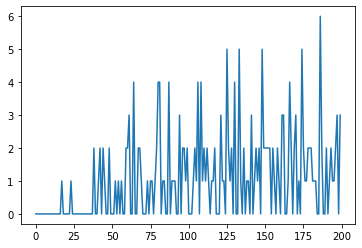

In [12]:
plt.plot(collisions_evo);

In [24]:
ic('Number of collision per cell', np.sum(arr_nb_colls, axis = (0)));

ic| 'Number of collision per cell': 'Number of collision per cell'
    np.sum(arr_nb_colls, axis = (0)): array([[605.],
                                             [743.],
                                             [719.],
                                             [693.],
                                             [672.],
                                             [653.],
                                             [634.],
                                             [612.],
                                             [594.],
                                             [574.]])


<IPython.core.display.Javascript object>


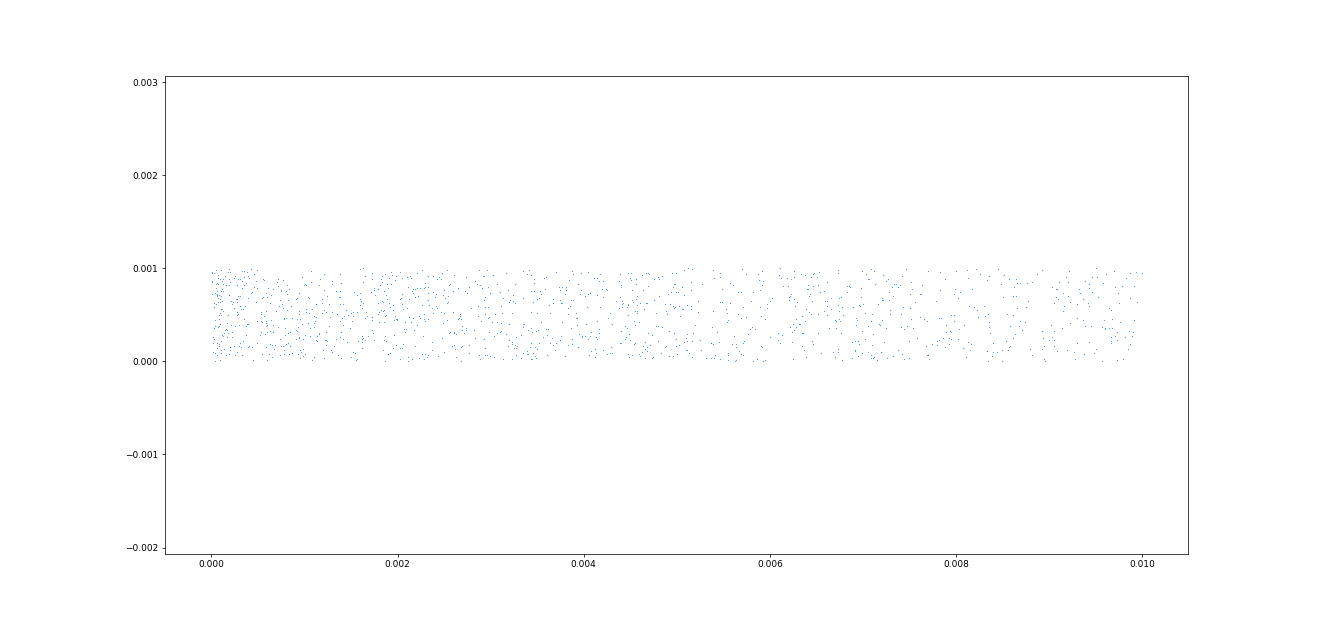

In [25]:
it = 50
plt.scatter(df.loc[df.index == it]['x'], df.loc[df.index == it]['y'], s = 0.1)
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


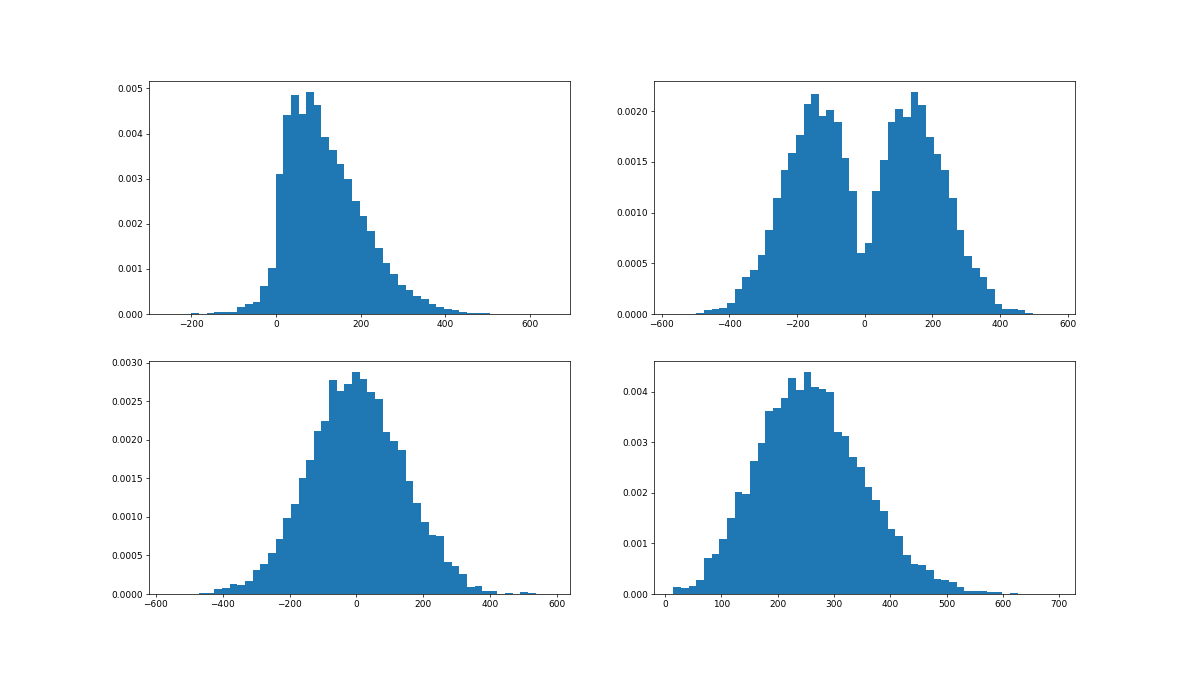

In [41]:
fig, ax = plt.subplots(2,2)
# df_it = df.loc[df.index == 999]
iterations = [k for k in range(800,1000)]
df_it = df.loc[np.isin(df.index,iterations)]
ax[0,0].hist(df_it['vx'], bins = 50, density = True)
ax[0,1].hist(df_it['vy'], bins = 50, density = True)
ax[1,0].hist(df_it['vz'], bins = 50, density = True)
ax[1,1].hist(np.sqrt(df_it['vx']**2+df_it['vy']**2+df_it['vz']**2), bins = 50, density = True);

<IPython.core.display.Javascript object>


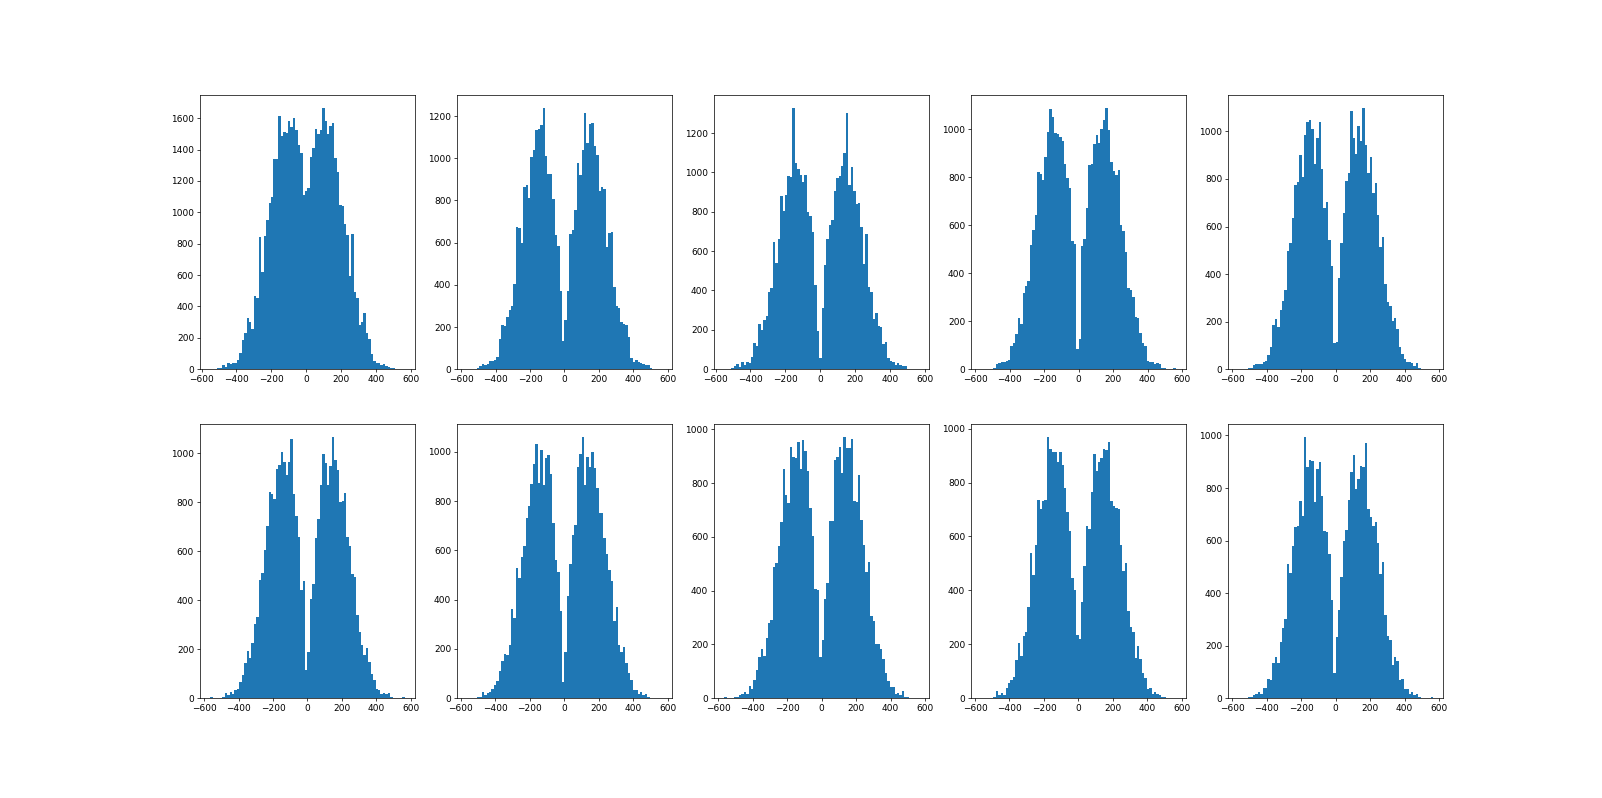

In [30]:
iterations = [k for k in range(800,1000)]
fig, axes = plt.subplots(2,5, figsize = (20,10))
axes = axes.flatten()
for k in range(len(axes)):
    axes[k].hist(df.loc[np.isin(df.index,iterations) & (df['x']<(k+1)*0.001) & (df['x']>k*0.001)]['vy'], bins = 80)
plt.show()

In [ ]:
iterations = [k for k in range(800,1000)]
fig, axes = plt.subplots(3,30, figsize = (40,15))
# print(axes.shape)
# axes = axes.flatten()
for j in range(axes.shape[0]):
    for i in range(axes.shape[1]):
        axes[j,i].hist(df.loc[np.isin(df.index,iterations) & (df['y']<(j+1)*0.00033) & (df['y']>j*0.00033) & (df['x']<(i+1)*0.00033) & (df['x']>i*0.00033)]['vy'], bins = 100)
plt.show()

In [ ]:
iterations = [k for k in range(500,1000)]
plt.hist(df.loc[np.isin(df.index,iterations)]['vx'], bins = 100);

In [ ]:
iterations = [k for k in range(500,1000)]
plt.hist(df.loc[np.isin(df.index,iterations)]['vz'], bins = 100);

In [ ]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.style.use('seaborn-pastel')

def update_hist(num, df):
    #plt.cla() # to clear the current figure
    dfit = df.loc[df.index == num]
    # since we modifying scat we dont want to use plt.cla
    scat.set_offsets(np.c_[dfit['x'],dfit['y']])
    # scat.set_array(df['speed_norm'])
    # plot_grid(ax, resolutions, system_shape)
    ax.set_title('{}/{}'.format(num+1, 1000), fontsize=15)

fig, ax = plt.subplots()

dfit = df.loc[df.index == 0]
scat = ax.scatter(dfit['x'], dfit['y'], s=0.3, cmap='seismic') #  c = df['speed_norm']
plot_boundaries(ax, segments)
plot_grid(ax, resolutions, system_shape)
ax.set_title('{}/{}'.format(1, 1000), fontsize=12)

# ax.axis('equal')
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)

ax.axis('equal')
# min_x, min_y, max_x, max_y = min(df['x']), min(df['y']), max(df['x']), max(df['y'])
ax.set(xlim=(-0.001, 0.011), ylim=(-0.0001, 0.0011))

interval = 40 # 25 images per second

anim = FuncAnimation(fig, update_hist, interval=interval, frames=1000, fargs=(df, ), save_count=1000)
plt.show()
# anim.save('system_evo.mp4', dpi = 300)

# Bug correcting

In [ ]:
# ic(arr.shape)
# ic(positions_save.shape) # in theory should be bigger

pos_in_arr = 5
delete_size_before = np.where(idxes_out<pos_in_arr)[0].size
ic(delete_size_before);
ic(positions_save[pos_in_arr+delete_size_before:pos_in_arr+2*delete_size_before]); # 343 for the new one
ic(arr[pos_in_arr]);

In [ ]:
ic(positions_save);

In [ ]:
ic(arr);

In [ ]:
ic(a);

In [ ]:
# part = np.expand_dims(positions_save[343], axis = 0)
#part = np.array([[9.35610527e-04, 1.81292102e-03, 1.12931941e+02, 2.18826846e+02,
#                            1.07789277e+02]])
part = np.array([[5.08818506e-03, -4.73498491e-04,  1.05394906e+02,
                 -2.43209455e+02,  4.19907637e+01]])
ic(part);

In [ ]:
ct, cp = handler_wall_collision(part, segments, a, radius)
ic(ct);
ic(cp)
count, idxes_out_ = make_collisions_out_walls(part, a, ct, cp, idx_out_walls, None) # idxes_out : indexes of the particles (in arr) that got out of the system

ic(idxes_out_);
ic(part);

In [ ]:
ct, cp = handler_wall_collision_point(part, segments, a)
ic(ct);
ic(cp)
count, idxes_out_ = make_collisions_out_walls(part, a, ct, cp, idx_out_walls, None) # idxes_out : indexes of the particles (in arr) that got out of the system

ic(idxes_out_);
ic(part);

In [ ]:
A = np.array([1,2,3,4,5,6,7,8,9,10])
delete = np.array([2,4,3,9,7])
print(np.delete(A,delete)) # keeps the order

In [ ]:
ic('0 = bottom',segments[0])
ic('1 = left', segments[1]);
ic('2 = right', segments[2]);
ic('3 = top',segments[3]);

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize = (15,10))
plot_boundaries(ax, segments)
plot_particles(ax, part, r = 3, arrows = True, factor = 0.0000002, line = True)
ax.axis('equal')